In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import imageio
from pathlib import Path

import embeddings
import clustering
import plotting
from IPython.display import Image
import numpy as np
import pickle

### Set up

In [2]:
DATA_PATH = Path('/media/neuroscout-data/neuroscout/file_data/stimuli/')

In [3]:
dataset_name = 'HealthyBrainNetwork'

In [4]:
frames = pd.read_csv('/media/neuroscout-data/neuroscout/datasets/raw/HealthyBrainNetwork/stimuli/all_frames.csv')
frame_paths = [str(DATA_PATH / Path(p).parts[-1]) for p in frames.path]

### Detect faces

In [5]:
# Load data
images_50, paths_50 = embeddings.load_detect_crop(frame_paths, minsize=50)

W0805 16:48:22.173451 139871789197120 deprecation_wrapper.py:119] From /home/alejandro/repos/face_priming/src/facenet/facenet/src/align/detect_face.py:280: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0805 16:48:22.175383 139871789197120 deprecation_wrapper.py:119] From /home/alejandro/repos/face_priming/src/facenet/facenet/src/align/detect_face.py:281: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



Creating networks and loading parameters


W0805 16:48:22.180758 139871789197120 deprecation_wrapper.py:119] From /home/alejandro/repos/face_priming/src/facenet/facenet/src/align/detect_face.py:125: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0805 16:48:22.183133 139871789197120 deprecation.py:506] From /home/alejandro/anaconda3/envs/tf_gpu_10/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0805 16:48:22.228967 139871789197120 deprecation_wrapper.py:119] From /home/alejandro/repos/face_priming/src/facenet/facenet/src/align/detect_face.py:177: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0805 16:48:22.347270 139871789197120 deprecation.py:323] From /home/alejandro/repos/face_priming

Loading, cropping, and aligning


In [6]:
len(images_50)

440

### Get embeddings

In [7]:
embs_50 = embeddings.get_embeddings(images_50)

W0805 16:49:39.458298 139871789197120 deprecation_wrapper.py:119] From /home/alejandro/repos/face_priming/src/facenet/facenet/src/facenet.py:418: The name tf.train.import_meta_graph is deprecated. Please use tf.compat.v1.train.import_meta_graph instead.



Model directory: /home/alejandro/repos/face_priming/models/20180402-114759
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275


W0805 16:49:48.509068 139871789197120 deprecation.py:323] From /home/alejandro/anaconda3/envs/tf_gpu_10/lib/python3.7/site-packages/tensorflow/python/training/queue_runner_impl.py:391: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W0805 16:49:48.555246 139871789197120 deprecation_wrapper.py:119] From /home/alejandro/repos/face_priming/src/facenet/facenet/src/facenet.py:419: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0805 16:49:48.556152 139871789197120 deprecation.py:323] From /home/alejandro/anaconda3/envs/tf_gpu_10/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to c

Calculating embeddings...


In [9]:
#Save intermediary
save_path = Path('/media/neuroscout-data/scratch/face_priming_save/')
pickle.dump(embs_50, (save_path / f'{dataset_name}_embs_50.pkl').open('wb'))
pickle.dump(paths_50, (save_path / f'{dataset_name}_paths_50.pkl').open('wb'))
pickle.dump(
    images_50, (save_path / f'{dataset_name}_cropped_images_50.pkl').open('wb'), 
    protocol=4)

### Cluster images

'plots/HealthyBrainNetwork_cw_t_067_min50.png'

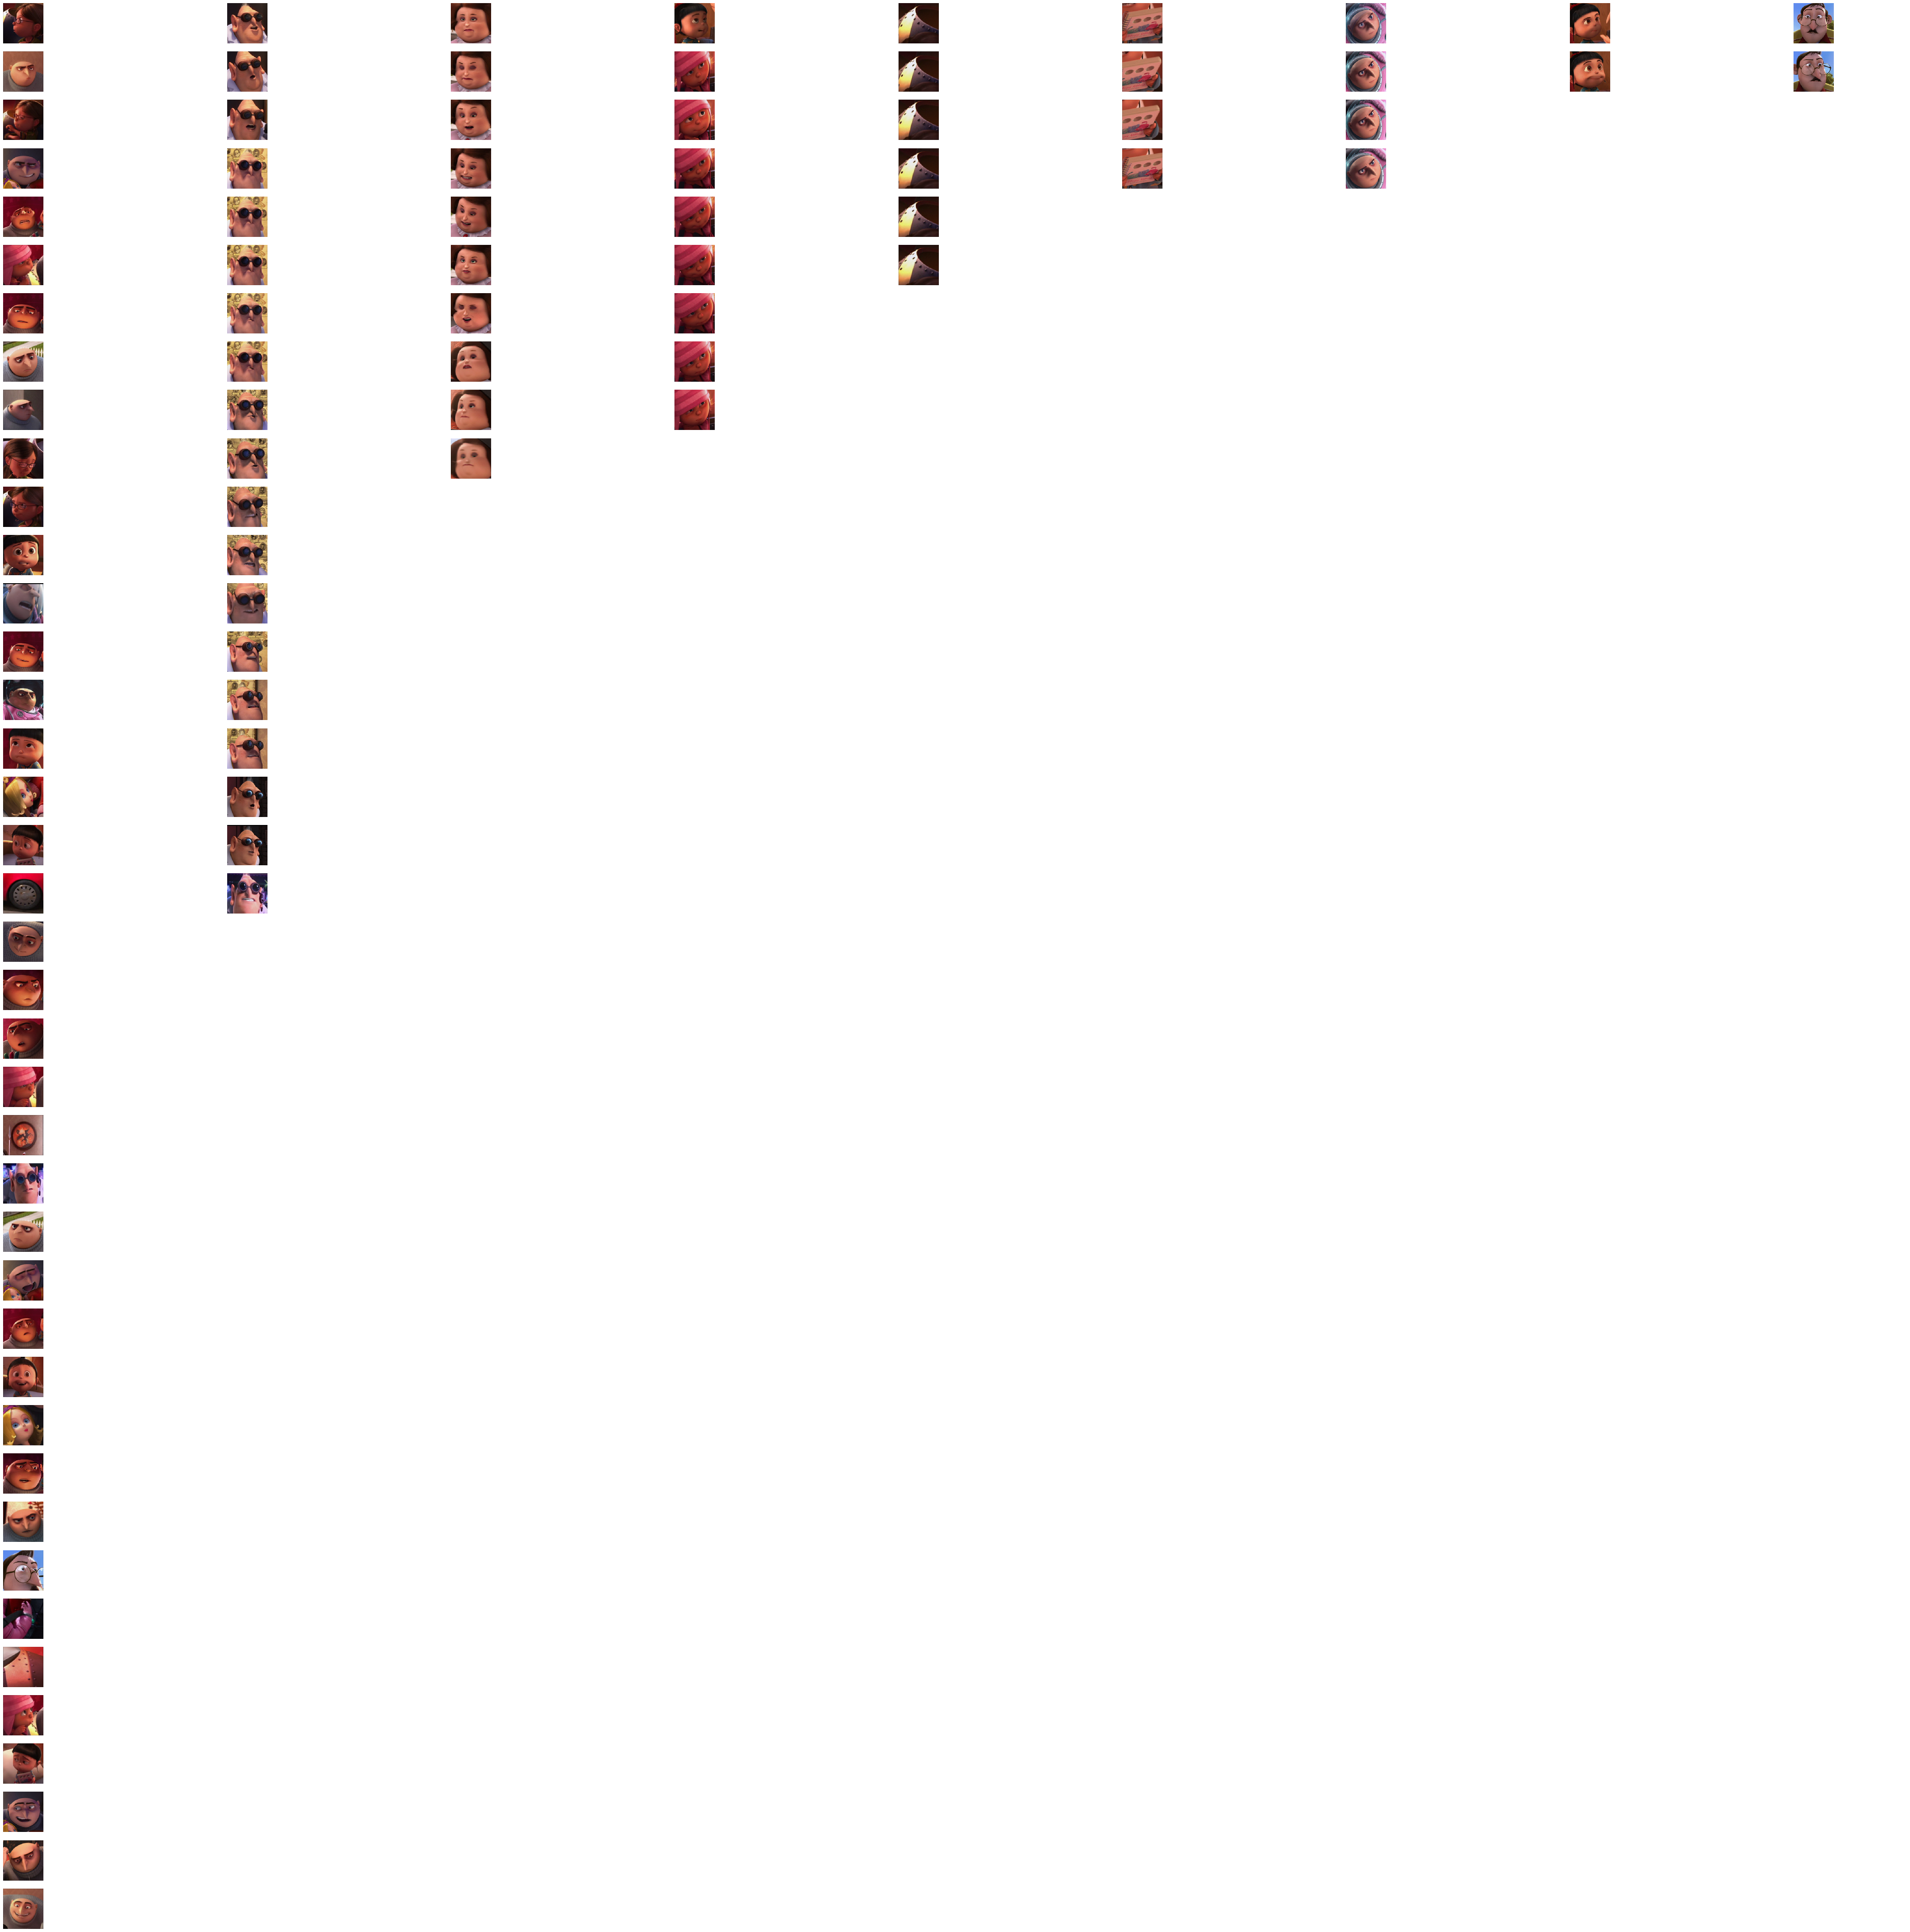

In [16]:
clusters50_67 = clustering.chinese_whispers(paths_50, images_50, embs_50, threshold=0.67)
plotting.plot_clusters(clusters50_67, n_sample=40, figsize=(80, 80), outfile=f'plots/{dataset_name}_cw_t_067_min50.png')

### Create predictors

#### Fine grained face detection

In [17]:
from importlib import reload
import regressors

In [18]:
frames['cond'] = 1
frames['run_number'] = 1

In [19]:
output = regressors.prepare_regressors(frames, paths_50, clusters50_67, bad_clusters=[])

In [22]:
select = output[['original_stim', 'onset', 'duration', 'face_count', 'any_faces', 
                'first_time_face', 'log_mean_time_since', 'log_max_time_since', 
                 'log_mean_face_time_cum', 'log_max_face_time_cum']]
event_files = []
for i, x in select.groupby('original_stim'):
    df = x.drop(columns=['original_stim'])
    fname = f'/home/alejandro/datasets/raw/{dataset_name}/stimuli/facenet/facenet_min50_t60_stim_{i}.tsv'
    df.to_csv(fname, sep='\t', index=False)
    event_files.append(fname)

### Upload

In [29]:
import pyns

In [30]:
descriptions = {
    "face_count": "Number of faces detected",
    "any_faces": "Binary indicator of face detection",
    "first_time_face": "First time a face is seen",
    "log_mean_time_since": "Time since last seen (mean b/w chars)",
    "log_max_time_since": "Time since last seen (max b/w chars)",
    "log_max_face_time_cum": "Cummulative time face seen (max b/w chars)",
    "log_mean_face_time_cum": "Cummulative time face seen (mean b/w chars)"
}

In [31]:
api = pyns.Neuroscout()

In [35]:
api.datasets.get()[1]['id']

8

In [36]:
dataset_id = 8
all_runs = api.runs.get(dataset_id=dataset_id)


In [44]:
formatted_runs = [[r['id'] for r in all_runs]]

In [45]:
event_files

['/home/alejandro/datasets/raw/HealthyBrainNetwork/stimuli/facenet/facenet_min50_t60_stim_despicable.me.transcode.mkv.tsv']

In [46]:
api.predictors.create_collection(
    'hbm_facenet_cw_min50_t67', dataset_id, formatted_runs, event_files, descriptions)

{'collection_name': 'hbm_facenet_cw_min50_t67',
 'id': 19,
 'predictors': [],
 'status': 'PENDING',
 'traceback': None,
 'uploaded_at': '2019-08-05T22:0'}

In [49]:
api.predictors.get_collection(19)

{'collection_name': 'hbm_facenet_cw_min50_t67',
 'id': 19,
 'predictors': [{'id': 19350, 'name': 'log_mean_face_time_cum'}],
 'status': 'PENDING',
 'traceback': None,
 'uploaded_at': '2019-08-05T22:0'}